In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
df_results = pd.read_csv('results.csv')

In [10]:
#### df_result processing ####

# make sure that for phase == 'eval' lines in df_results
# f_thres_train is filled with the value of pareto_output_f{f_thres_train}, where
# pareto_output_ appears in opts column
def extract_f_thres_train_from_row(row):
    opts = row['opts'].split(',')
    for opt in opts:
        if opt.startswith('pareto_output_f'):
            dir_name = opt.split('/')[0]
            f_thres_train = int(dir_name.split('_')[-1][1:])
            return f_thres_train
        elif opt.startswith('pareto_cifar/pareto_output_f'):
            dir_name = opt.split('/')[1]
            f_thres_train = int(dir_name.split('_')[-1][1:])
            return f_thres_train
df_results['f_thres_train'] = df_results.apply(
    lambda row: extract_f_thres_train_from_row(row) 
    if row['phase'] == 'eval' 
    else row['f_thres_train'], 
    axis=1,
)

/tmp/ipykernel_151283/2823628905.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['top1'] = df_curve['top1'].astype(float)
/tmp/ipykernel_151283/2823628905.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['top1'] = df_curve['top1'].astype(float)
/tmp/ipykernel_151283/2823628905.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

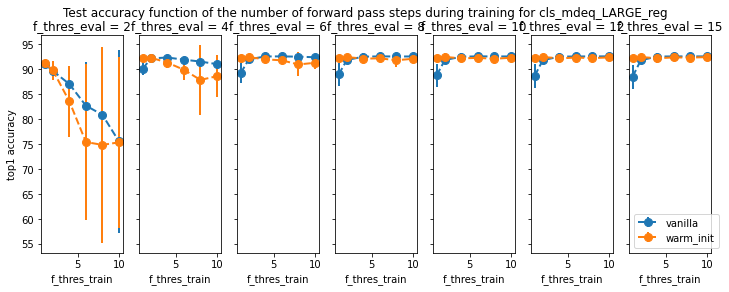

In [11]:
# f_thres_evals = [3, 6, 9, 18, 25]
f_thres_evals = [2, 4, 6, 8, 10, 12, 15]
model_size = 'LARGE_reg'
model_size = f'cls_mdeq_{model_size}'
model_size_warm = f'{model_size}_warm'
fig, axs = plt.subplots(1, len(f_thres_evals), sharey=True, figsize=(12, 4))
query_config = {
    'vanilla': {
        'warm_init': False,
    },
    'warm_init': {
        'warm_init': True,
    },
}

for i, f_thres_eval in enumerate(f_thres_evals):
    for curve_name, query_kwargs in query_config.items():
        warm_init = query_kwargs['warm_init']
        query = "warm_init == @warm_init & f_thres_val == @f_thres_eval & phase == 'eval' & (model_size == @model_size | model_size == @model_size_warm)"
        df_curve = df_results.query(query)
        df_curve['top1'] = df_curve['top1'].astype(float)
        # plot the top1 accuracy function of f_thres_train,
        # where the top1 accuracy is averaged over all the seeds
        # in addition, plot the standard deviation of the top1 accuracy
        # as an error bar for each data point
        df_curve_gp = df_curve.groupby(['f_thres_train'])
        top1_mean = df_curve_gp['top1'].mean()
        top1_std = df_curve_gp['top1'].std()
        axs[i].errorbar(
            top1_mean.index.values,
            top1_mean.values,
            yerr=top1_std.values,
            label=curve_name,
            marker='o',
            linestyle='--',
            linewidth=2,
            markersize=8,
        )
        axs[i].set_title(f'f_thres_eval = {f_thres_eval}')
        if i == 0:
            axs[i].set_ylabel('top1 accuracy')
        axs[i].set_xlabel('f_thres_train')
axs[-1].legend()
fig.suptitle(f'Test accuracy function of the number of forward pass steps during training for {model_size}')
plt.savefig(f'pareto_curve_{model_size}.png', dpi=300)